In [1]:
import os
import random

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms

from data_helper import UnlabeledDataset, LabeledDataset
#from my_data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box


from collections import OrderedDict

In [2]:
def draw_box(ax, corners, color):
    point_squence = torch.stack([corners[:, 0], corners[:, 1], corners[:, 3], corners[:, 2], corners[:, 0]])
    # the corners are in meter and time 10 will convert them in pixels
    # Add 400, since the center of the image is at pixel (400, 400)
    # The negative sign is because the y axis is reversed for matplotlib
    #ax.plot(point_squence.T[0] * 10 + 400, -point_squence.T[1] * 10 + 400, color=color)
    ax.plot(point_squence.transpose(0,1).numpy()[0] * 10 + 400, -point_squence.transpose(0,1).numpy()[1] * 10 + 400, color=color)

In [3]:
image_folder = '../data'
annotation_csv = '../data/annotation.csv'

random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

# You shouldn't change the unlabeled_scene_index
# The first 106 scenes are unlabeled
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
labeled_scene_index = np.arange(106, 134)

train_index = np.arange(106,128)
val_index = np.arange(106,110)
test_index = np.arange(132,134)

In [4]:
import math


def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.degrees(np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)))


def round_up(x):
    return int(math.ceil(x/50.0))*50

def round_down(x):
    return round_up(x) - 50

In [5]:
def new_collate_fn(batch):
    
    image = []
    road_images = []
    bboxes = []
    target = []
    
    for x in batch:
        sample = x[0]
        bbox = x[1]['bounding_box']
        #category = x[1]['category']
        extra = x[3]
        
        # first, stack the 6 images into 1       
        front = torch.cat( (torch.tensor(sample[0]), torch.tensor(sample[1]), torch.tensor(sample[2])), 2 )
        back = torch.cat( (torch.tensor(sample[3]), torch.tensor(sample[4]), torch.tensor(sample[5])), 2 )
        curr_image = torch.cat( (front, back), 1).transpose(2,1).flip(2)
        
        
        #print(curr_image.shape)
        #image.append(curr_image)
        image.append(torch.tensor(x[0][1]))
        
        # append current road map 
        road_images.append(x[2])
        
        # TODO: process bbox ???
        current_bbs = []
        count = 0
        
        bb_cand = (-100., -100.)
        for i, corners in enumerate(bbox):
            point_squence = torch.stack([corners[:, 0], corners[:, 1], corners[:, 3], corners[:, 2]])
            xs = point_squence.transpose(0,1)[0] * 10 + 400
            ys = -point_squence.transpose(0,1)[1] * 10 + 400
            
            center_x, center_y = 0.5*(xs[0] + xs[1]), 0.5*(ys[0] + ys[1])
            current_bbs.append((xs,ys))
            count += 1
        
        # for now only store the count
        target.append(count)
        bboxes.append(current_bbs)
    
    return torch.stack(image), torch.stack(target), torch.stack(road_images)

In [14]:
def front_collate_fn(batch):
    front_imgs = []
    front_right_imgs = []
    front_left_imgs = []
    target = []
    road_imgs = []
    bbs = []
    for x in batch:
        
        # first, stack the 6 images into 1    
        front = torch.cat( (torch.tensor( x[0][0] ), torch.tensor( x[0][1] ), torch.tensor( x[0][2] )), 2 )
        back = torch.cat( (torch.tensor( x[0][3] ), torch.tensor( x[0][4] ), torch.tensor( x[0][5] )), 2 )
        curr_image = torch.cat( (front, back), 1).transpose(2,1).flip(2)
        #curr_image = torch.cat( (front, back), 1)
        front_imgs.append(curr_image)
        
        
        # append current road map 
        road_imgs.append(x[2])
        
        # target
        current_bbs = []
        x_min = 800
        count = 0
        
        for i, corners in enumerate(x[1]['bounding_box']):
            # Get bird's eye view coordinates. 
            point_squence = torch.stack([corners[:, 0], corners[:, 1], corners[:, 3], corners[:, 2]])
            xs = point_squence.T[0] * 10 + 400
            ys = -point_squence.T[1] * 10 + 400
            if xs[2] - xs[0] > 5:
                top_center_x, top_center_y = 0.5*(xs[2] + xs[3]), 0.5*(ys[2] + ys[3])
            else:
                top_center_x, top_center_y = 0.5*(xs[0] + xs[1]), 0.5*(ys[0] + ys[1])
        
            count += 1
            current_bbs.append((xs, ys))
            
        target.append(count)
        bbs.append(current_bbs)
                
    boom = torch.stack(front_imgs), torch.tensor(target), torch.stack(road_imgs), bbs
    return boom

In [15]:
transform = torchvision.transforms.ToTensor()

train_transform = transforms.Compose([
    transforms.RandomApply([
        transforms.ColorJitter(brightness = 0.5, contrast = 0.3, saturation = 0.2, hue = (-0.3, 0.3)),
        transforms.Grayscale(3),
    ]),
    transforms.ToTensor(),
])


labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=train_index,
                                  transform=train_transform,
                                  extra_info=True
                                 )

labeled_valset = LabeledDataset(image_folder=image_folder,
                                annotation_file=annotation_csv,
                                scene_index=val_index,
                                transform=transform,
                                extra_info=True
                               )

trainloader = torch.utils.data.DataLoader(labeled_trainset, batch_size=16, shuffle=False, num_workers=2, collate_fn=front_collate_fn)
valloader = torch.utils.data.DataLoader(labeled_valset, batch_size=16, shuffle=False, num_workers=2, collate_fn=front_collate_fn)


sample, target, road_image, bbs = iter(trainloader).next()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added 

In [16]:
sample.shape

torch.Size([16, 3, 918, 512])

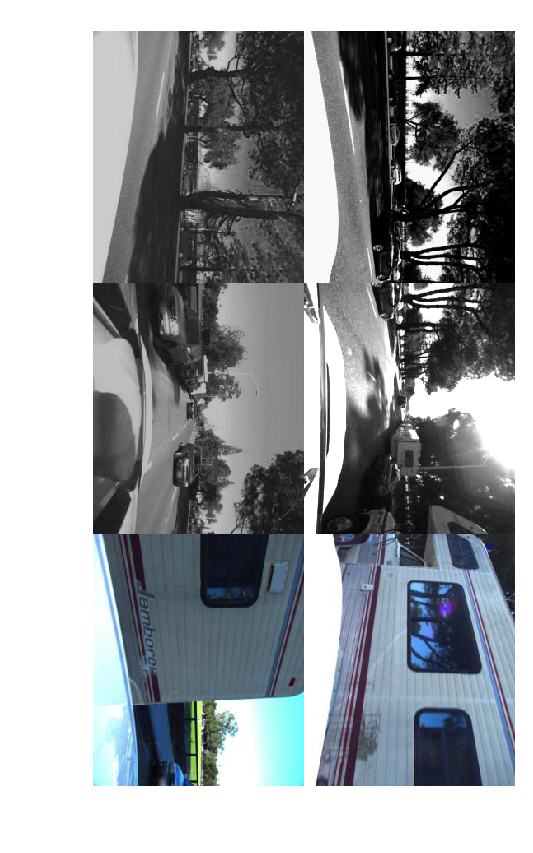

In [17]:
plt.imshow(sample[0].numpy().transpose(1, 2, 0))
plt.axis('off');

In [10]:
target[0]

tensor(21)

In [18]:
road_image.shape

torch.Size([16, 800, 800])

In [14]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('cpu')

class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        
        self.encoder = torchvision.models.resnet18()
        self.encoder.fc = nn.Identity()
        
        self.classification = nn.Sequential(OrderedDict([
            ('linear1', nn.Linear(512, 40)),
        ]))
        
    def forward(self, x):
        x = self.encoder(x)
        return self.classification(x)

In [15]:
model = SimpleModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
best_val_loss = 100

In [16]:

epochs = 20

for epoch in range(epochs):
    
    model.train()
    train_losses = []
    
    # sample, target, road_image, bbs 
    for i, (sample, target, road_img, bbs) in enumerate(trainloader):
        optimizer.zero_grad()
        
        sample = sample.to(device)
        target = target.to(device)
        
        y_hat = model(sample)
        loss = criterion(y_hat, target.long())
        
        train_losses.append(loss.item())

        loss.backward()
        optimizer.step()

        if i % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(sample), len(trainloader.dataset),
                10. * i / len(trainloader), loss.item()))

    print("\nAverage Train Epoch Loss: ", np.mean(train_losses))
    
    
    model.eval()
    val_losses = []
    
    for i, (sample, target, road_img, bbs) in enumerate(valloader):
        model.eval()
        sample = sample.to(device)
        target = target.to(device)
        
        with torch.no_grad():
            y_hat = model(sample)
            loss = criterion(y_hat, target.long())

            val_losses.append(loss.item())

        if i % 10 == 0:
            print('Val Epoch: {} [{}/{} ({:.0f}%)]\tAverage Loss So Far: {:.6f}'.format(
                epoch, i * len(sample), len(valloader.dataset),
                5. * i / len(valloader), np.mean(val_losses)))
            
    print("Average Validation Epoch Loss: ", np.mean(val_losses))
    global best_val_loss
    if np.mean(val_losses) < best_val_loss:
        best_val_loss = np.mean(val_losses)
        torch.save(model.state_dict(), 'best_val_loss_counting_simple.pt')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added 

Train Epoch: 0 [0/2772 (0%)]	Loss: 3.724258
Train Epoch: 0 [160/2772 (1%)]	Loss: 3.729423
Train Epoch: 0 [320/2772 (1%)]	Loss: 3.619143
Train Epoch: 0 [480/2772 (2%)]	Loss: 3.241448
Train Epoch: 0 [640/2772 (2%)]	Loss: 3.818676
Train Epoch: 0 [800/2772 (3%)]	Loss: 3.468072


IndexError: Target 41 is out of bounds.